# Convert Hands CNN and Detector from ONNX to TFLite

### Hands CNN + Detector Conversion

In [7]:
import sys
import tensorflow as tf
import onnx_tf
import onnx
import numpy as np

sys.path.append("D:\Programming\cybertruck")

In [8]:
model_name = 'hands_cnn'

### Now Prepare the Onnx model for tensorflow and then convert to tflite

https://medium.com/@zergtant/convert-pytorch-model-to-tf-lite-with-onnx-tf-232a3894657c

In [10]:
def convert_onnx_to_tflite(model_name):
    # Load  ONNX model
    onnx_model = onnx.load(f'{model_name}.onnx')

    # Convert ONNX model to TensorFlow format
    tf_model = onnx_tf.backend.prepare(onnx_model)
    # Export  TensorFlow  model 
    tf_model.export_graph(f'{model_name}.tf')

    # Then convert from TF to TFLite
    converter = tf.lite.TFLiteConverter.from_saved_model(f'{model_name}.tf')
    tflite_model = converter.convert()
    open(f'{model_name}.tflite', 'wb').write(tflite_model)

convert_onnx_to_tflite(model_name)

INFO:absl:Function `__call__` contains input name(s) x, y with unsupported characters which will be renamed to transpose_51_x, mul_3_y in the SavedModel.
INFO:absl:Found untraced functions such as gen_tensor_dict while saving (showing 1 of 1). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: hands_cnn.tf\assets


INFO:tensorflow:Assets written to: hands_cnn.tf\assets
INFO:absl:Writing fingerprint to hands_cnn.tf\fingerprint.pb


### Now test the converted model

https://www.tensorflow.org/lite/guide/inference
https://www.tensorflow.org/lite/guide/inference#run_inference_with_dynamic_shape_model

Note that by default, this model takes a batch size of 1. Which works out well since we want real time performance

In [11]:
def test_tflite_model(model_name):
    model_filename = f"{model_name}.tflite"

    # Load the TFLite model and allocate tensors.
    interpreter = tf.lite.Interpreter(model_path=model_filename)
    interpreter.allocate_tensors()

    # Get input and output tensors.
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Test the model on random input data.
    input_shape = input_details[0]['shape']
    print(input_shape)
    input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
    interpreter.set_tensor(input_details[0]['index'], input_data)

    interpreter.invoke()

    # The function `get_tensor()` returns a copy of the tensor data.
    # Use `tensor()` in order to get a pointer to the tensor.
    output_data = interpreter.get_tensor(output_details[0]['index'])
    print(output_data)

test_tflite_model(model_name)

[  1   3 224 224]
[[ 0.32840687 -0.18751231 -0.39046922 -0.06014181  0.09444401 -0.16509481
  -0.0332681   0.2817672   0.27923384  0.05101268]]


In [12]:
def test_dynamic_batches_tflite(model_name):
    model_filename = f"{model_name}.tflite"

    # Load the TFLite model in TFLite Interpreter
    interpreter = tf.lite.Interpreter(model_path=model_filename)

    input_shape = interpreter.get_input_details()[0]['shape']
    input_shape[0] = 5 # Set to batch size of 5 instead of the default 1

    # Resize input shape for dynamic shape model and allocate tensor
    interpreter.resize_tensor_input(interpreter.get_input_details()[0]['index'], input_shape)
    interpreter.allocate_tensors()

    # Get input and output tensors.
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    print(input_details) # Here we can see the input size has changed to (5, 3, 299, 299) 
    print(output_details) # The output has the corresponding changes

    input_data = np.array(np.random.random_sample((5, 3, 224, 224)), dtype=np.float32)
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()

    output_data = interpreter.get_tensor(output_details[0]['index'])
    print(output_data)

test_dynamic_batches_tflite(model_name)

[{'name': 'serving_default_input:0', 'index': 0, 'shape': array([  5,   3, 224, 224]), 'shape_signature': array([ -1,   3, 224, 224]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'PartitionedCall:0', 'index': 112, 'shape': array([ 1, 10]), 'shape_signature': array([-1, 10]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[[ 0.19255352 -0.20259045 -0.45786604 -0.16824155  0.02376414 -0.0886738
   0.06660599  0.35306084  0.32234243  0.15734895]
 [ 0.24007726 -0.27200994 -0.38724354 -0.03633209  0.16200924 -0.21717854
   0.05402472  0.29684362  0.28966203  0.07816407]
 [ 0.40500665 -0.20663378 -0.55069536 -0.12373332  0.07907346 -0.11458767

## Now Convert the Detector from Pytorch to TFLite with Ultralytics

In [15]:
detector_path = 'best_hands_detector.pt'

In [18]:
from ultralytics import YOLO

model = YOLO(detector_path)  # load a custom trained model

# Export the model
model.export(format='tflite')

Ultralytics YOLOv8.0.220 🚀 Python-3.10.8 torch-1.13.1+cu117 CPU (Intel Core(TM) i5-9300H 2.40GHz)
Model summary (fused): 168 layers, 3006038 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from 'best_hands_detector.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 6, 8400) (6.0 MB)
requirements: Ultralytics requirements ['onnx2tf>=1.15.4,<=1.17.5', 'sng4onnx>=1.0.1', 'onnxsim>=0.4.33', 'onnx_graphsurgeon>=0.3.26', 'tflite_support', 'onnxruntime'] not found, attempting AutoUpdate...
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ------------------------------------- 400.4/400.4 kB 12.6 MB/s eta 0:00:00
     ---------------------------------------- 1.2/1.2 MB 19.9 MB/s eta 0:00:00
     ---------------------------------------- 42.1/42.1 kB ? eta 0:00:00
     ------------------------------------- 390.3/390.3 kB 25.3 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  

'best_hands_detector_saved_model\\best_hands_detector_float32.tflite'

## Testing Usage of TFLite Model

In [41]:
tflite_model_path = r"D:\Programming\cybertruck\conversions\best_hands_detector_saved_model\best_hands_detector_float32.tflite"

# Load the TFLite model in TFLite Interpreter
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details() # (1, 640, 640, 3) Notice that the RGB channel is at the end for the detector..
output_details = interpreter.get_output_details()

input_data = np.array(np.random.random_sample(input_details[0]['shape']), dtype=np.float32)

print(input_details) # Here we can see the input size has changed to (5, 3, 299, 299) 
print(output_details) # The output has the corresponding changes

interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()

output = interpreter.get_tensor(output_details[0]['index'])
print(output)

# Obtaining output results
output = interpreter.get_tensor(output_details[0]['index'])
output = output[0]
output = output.T

boxes_xywh = output[..., :4] #Get coordinates of bounding box, first 4 columns of output tensor
scores = np.max(output[..., 5:], axis=1) #Get score value, 5th column of output tensor
classes = np.argmax(output[..., 5:], axis=1) # Get the class value, get the 6th and subsequent columns of the output tensor, and store the largest value in the output tensor.

print(boxes_xywh)
print(scores)
print(classes)

[{'name': 'inputs_0', 'index': 0, 'shape': array([  1, 640, 640,   3]), 'shape_signature': array([  1, 640, 640,   3]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'Identity', 'index': 408, 'shape': array([   1,    6, 8400]), 'shape_signature': array([   1,    6, 8400]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[[[   0.022322     0.02661    0.044909 ...      0.8554     0.91581     0.96214]
  [   0.036164    0.020606    0.011034 ...     0.96839     0.96751      0.9596]
  [   0.046957    0.054584     0.10105 ...     0.23594     0.16194    0.081007]
  [   0.072482    0.041137    0.022036 ...    0.063368    0.065932    0.081348]
  [ 3.

## Example Detector Inference with TFLite

https://github.com/ultralytics/ultralytics/issues/4827

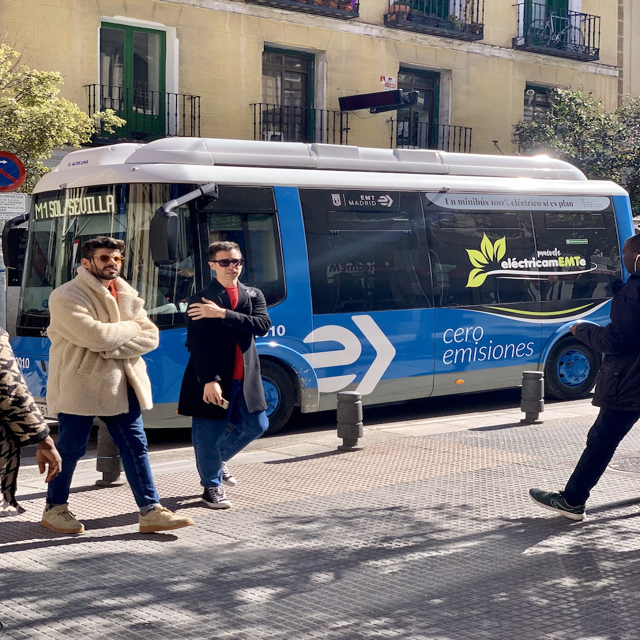

In [42]:
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display

tflite_model_path = r"D:\Programming\cybertruck\conversions\best_hands_detector_saved_model\best_hands_detector_float32.tflite"
image_path = r"D:\Programming\cybertruck\conversions\bus.jpg"

def run_model_and_draw_results(model_path, image_path):
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Obtain the height and width of the corresponding image from the input tensor
    image_height = input_details[0]['shape'][1] # 640
    image_width = input_details[0]['shape'][2] # 640

    # Image Preparation
    image = Image.open(image_path)
    image_resized = image.resize((image_width, image_height)) # Resize the image to the corresponding size of the input tensor and store it in a new variable

    image_np = np.array(image_resized) #
    image_np = np.true_divide(image_np, 255, dtype=np.float32) 
    image_np = image_np[np.newaxis, :]

    # inference
    interpreter.set_tensor(input_details[0]['index'], image_np)

    interpreter.invoke()

    # Obtaining output results
    output = interpreter.get_tensor(output_details[0]['index'])
    output = output[0]
    output = output.T

    boxes_xywh = output[..., :4] #Get coordinates of bounding box, first 4 columns of output tensor
    scores = np.max(output[..., 5:], axis=1) #Get score value, 5th column of output tensor
    classes = np.argmax(output[..., 5:], axis=1) # Get the class value, get the 6th and subsequent columns of the output tensor, and store the largest value in the output tensor.

    # Threshold Setting
    threshold = 0.3

    # Bounding boxes, scores, and classes are drawn on the image
    draw = ImageDraw.Draw(image_resized)

    for box, score, cls in zip(boxes_xywh, scores, classes):
        if score >= threshold:
            x_center, y_center, width, height = box
            x1 = int((x_center - width / 2) * image_width)
            y1 = int((y_center - height / 2) * image_height)
            x2 = int((x_center + width / 2) * image_width)
            y2 = int((y_center + height / 2) * image_height)

            draw.rectangle([x1, y1, x2, y2], outline="red", width=2)
            text = f"Class: {cls}, Score: {score:.2f}"
            draw.text((x1, y1), text, fill="red")

    display(image_resized)

run_model_and_draw_results(tflite_model_path, image_path)

# Converting Model for Pytorch Android deployment

https://pytorch.org/mobile/android/

In [12]:
import torch, yaml
from ultralytics import YOLO
import torchvision
from torch.utils.mobile_optimizer import optimize_for_mobile

model = YOLO(r"D:\Programming\cybertruck\conversions\best_hands_detector.pt")  # load a custom trained model

# x = torch.rand(1, 3, 640, 640)

model.export(format='torchscript')

'''
traced_script_module = torch.jit.trace(model, x)
traced_script_module_optimized = optimize_for_mobile(traced_script_module)
traced_script_module_optimized._save_for_lite_interpreter("./hands_detector_model.ptl")
'''
# model(x)

# ops = torch.jit.export_opnames(model)
# with open('MobileNetV2.yaml', 'w') as output:
#    yaml.dump(ops, output)

Ultralytics YOLOv8.0.220 🚀 Python-3.10.8 torch-1.13.1+cu117 CPU (Intel Core(TM) i5-9300H 2.40GHz)
Model summary (fused): 168 layers, 3006038 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from 'D:\Programming\cybertruck\conversions\best_hands_detector.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 6, 8400) (6.0 MB)

TorchScript: starting export with torch 1.13.1+cu117...
TorchScript: export success ✅ 3.9s, saved as 'D:\Programming\cybertruck\conversions\best_hands_detector.torchscript' (11.9 MB)

Export complete (6.5s)
Results saved to D:\Programming\cybertruck\conversions
Predict:         yolo predict task=detect model=D:\Programming\cybertruck\conversions\best_hands_detector.torchscript imgsz=640  
Validate:        yolo val task=detect model=D:\Programming\cybertruck\conversions\best_hands_detector.torchscript imgsz=640 data=/home/ron/Classes/CV-Systems/cybertruck/detection/hands_detection/egohands.yaml  
Visualize:       https://netron.app


AttributeError: module 'torch' has no attribute 'git'

In [15]:
torchscript_model = torch.jit.load('./best_hands_detector.torchscript')
torchscript_model_optimized = optimize_for_mobile(torchscript_model)
torch.jit.save(torchscript_model_optimized, 'best_hands_detector.ptl')

In [18]:
torchscript_lite_model = torch.jit.load('./best_hands_detector.torchscript')

x = torch.rand(1, 3, 640, 640)

output = torchscript_lite_model(x)

output.shape

torch.Size([1, 6, 8400])